### Using cross validation to find best `k` for k-Nearest Neighbors in order to predict label of test images from cifar-10

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
def prepare_data(files):
    batch_dir = "cifar-10-batches-py\\"
    #files = files # ["data_batch_1", "data_batch_2"]
    key_data = "data".encode('UTF-8')
    key_labels = "labels".encode('UTF-8')
    
    all_data = np.empty([0, 3072], dtype=np.uint8)
    all_labels = []

    for d in files:
        dict_cifar = unpickle(batch_dir+d) # unpickle file to dict
        data = dict_cifar.get(key_data) #data_from_dict(dict_cifar) # get data from dict
        labels = list(dict_cifar.get(key_labels))
        all_data = np.concatenate((all_data, data), axis=0)
        all_labels.append(labels) # np.concatenate((all_labels, labels), axis=0)

    return all_data, np.array(all_labels).flatten()

In [4]:
train_data_files = ["data_batch_1"]
X_train, y_train = prepare_data(files = train_data_files)

## Cross validation

In [5]:
from sklearn.neighbors import KNeighborsClassifier
import time

num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
accuracies = [] # list of accuracies

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

num_k_choices = len(k_choices) # 5 # first n value from k_choices
ts_start = time.time() # start timing
for k in k_choices: #[:num_k_choices]:
    print("{}-Nearest Neighbors".format(k))
    clf = KNeighborsClassifier(n_neighbors=k, weights="uniform")

    for i in range(num_folds): # run cross validation num_folds times
        X_train_folds = np.array_split(X_train, num_folds)
        y_train_folds = np.array_split(y_train, num_folds)
        
        split = np.random.randint(num_folds) # generate random number for determining validation set
        # features
        X_validation_set = np.array(X_train_folds.pop(split)) # pop the array from the fold and use it as validation
        X_train_set = np.array(X_train_folds) # 
        d1, d2, d3 = np.array(X_train_set).shape # convert to numpy array to get shape
        X_train_set = X_train_set.reshape(d1*d2, d3)
        
        # labels
        y_validation_set = np.array(y_train_folds.pop(split))
        y_train_set = np.array(y_train_folds).ravel()
        
        # train
        clf.fit(X=X_train_set, y=y_train_set)
        
        # predict
        y_test_pred = clf.predict(X=X_validation_set)
        
        num_test = y_validation_set.shape[0] # number of all tests
        # Compute and print the fraction of correctly predicted examples
        num_correct = np.sum(y_test_pred == y_validation_set)
        accuracy = float(num_correct) / num_test
        accuracies.append(accuracy)
        print("\tRun %d: %d/%d. Accuracy: %f" % (i, num_correct, num_test, accuracy))

ts_end = time.time()
print("Run time: {} minutes".format(round((ts_end-ts_start)/60, 2)))

1-Nearest Neighbors
	Run 0: 568/2000. Accuracy: 0.284000
	Run 1: 554/2000. Accuracy: 0.277000
	Run 2: 577/2000. Accuracy: 0.288500
	Run 3: 549/2000. Accuracy: 0.274500
	Run 4: 554/2000. Accuracy: 0.277000
3-Nearest Neighbors
	Run 0: 575/2000. Accuracy: 0.287500
	Run 1: 557/2000. Accuracy: 0.278500
	Run 2: 575/2000. Accuracy: 0.287500
	Run 3: 575/2000. Accuracy: 0.287500
	Run 4: 548/2000. Accuracy: 0.274000
5-Nearest Neighbors
	Run 0: 550/2000. Accuracy: 0.275000
	Run 1: 550/2000. Accuracy: 0.275000
	Run 2: 589/2000. Accuracy: 0.294500
	Run 3: 550/2000. Accuracy: 0.275000
	Run 4: 557/2000. Accuracy: 0.278500
8-Nearest Neighbors
	Run 0: 548/2000. Accuracy: 0.274000
	Run 1: 548/2000. Accuracy: 0.274000
	Run 2: 568/2000. Accuracy: 0.284000
	Run 3: 568/2000. Accuracy: 0.284000
	Run 4: 597/2000. Accuracy: 0.298500
10-Nearest Neighbors
	Run 0: 568/2000. Accuracy: 0.284000
	Run 1: 568/2000. Accuracy: 0.284000
	Run 2: 574/2000. Accuracy: 0.287000
	Run 3: 570/2000. Accuracy: 0.285000
	Run 4: 574

### Mean values for accuracies for each kNN

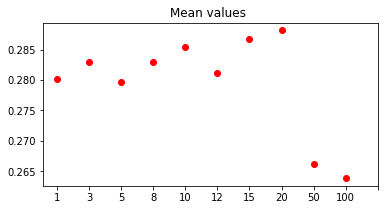

In [6]:
acc = np.array(accuracies).reshape(num_k_choices, num_folds) # matrix with row per accuracy results per kNN
acc_mean = np.mean(acc, axis=1) # mean per row

plt.figure(figsize=(6,3))
plt.plot(acc_mean, "ro")
plt.xticks([x for x in range(len(k_choices)+1)], k_choices)
plt.title("Mean values ")
plt.show()

### Accuracies for each kNN for each run

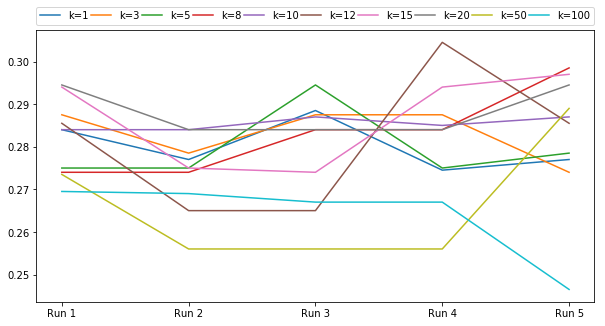

In [7]:
line=[]
plt.figure(figsize=(10,5))

for i in range(num_k_choices):
    line.append(plt.plot(acc[i], label="k={}".format(k_choices[i])))

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=num_k_choices, mode="expand", borderaxespad=0.)
plt.xticks([0,1,2,3,4], ["Run "+str(x+1) for x in range(num_folds+1)])
plt.show()

#### `k=12` delivers accuracy over 0,3 in run 4. That is the `k` used in the following code when train is run on whole dataset.

### Run on all train data with `k` that has delivered highest accuracy

In [8]:
best_k = 12

ts_start = time.time()
train_data_files = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5"]
X_train_all, y_train_all = prepare_data(files = train_data_files)

test_data_files = ["test_batch"]
X_test, y_test = prepare_data(files = test_data_files)

clf = KNeighborsClassifier(n_neighbors=best_k, weights="uniform")
# train
clf.fit(X=X_train_all, y=y_train_all)

# predict
y_test_pred = clf.predict(X=X_test)

num_test = y_test.shape[0] # number of all tests
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("%d/%d. Accuracy: %f" % (num_correct, num_test, accuracy))

ts_end = time.time()
print("Run time: {} minutes".format(round((ts_end-ts_start)/60, 2)))

3429/10000. Accuracy: 0.342900
Run time: 45.82 minutes


#### Training the model on whole dataset - 60.000 observations and testing it on the model with `k=12` yields 34% accuracy.